In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

from init import *


Getting English data
Getting French data
Getting emotion words and bird names


In [2]:
# precompute measures
k = 100
t1, t2 = 9, -1
t3 = -2
pos = NOUN

measures_emotion_eng = nn_measure_over_words(words_eng, pos, pos_data, data, t1, t2, k)
measures_emotion_fra = nn_measure_over_words(words_fr, pos, pos_data_fr, data_fr, t1, t2, k)
measures_emotion_eng_late = nn_measure_over_words(words_eng, pos, pos_data, data, t3, t2, k)


In [3]:
# precompute embedding prototypicality
words_e = list(measures_emotion_eng.keys())
emotion_emproto_eng = prototype_density(words_e, data, t1) 
words_f = list(measures_emotion_fra.keys())
emotion_emproto_fra = prototype_density(words_f, data_fr, t1)  


/Users/johnxu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/johnxu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


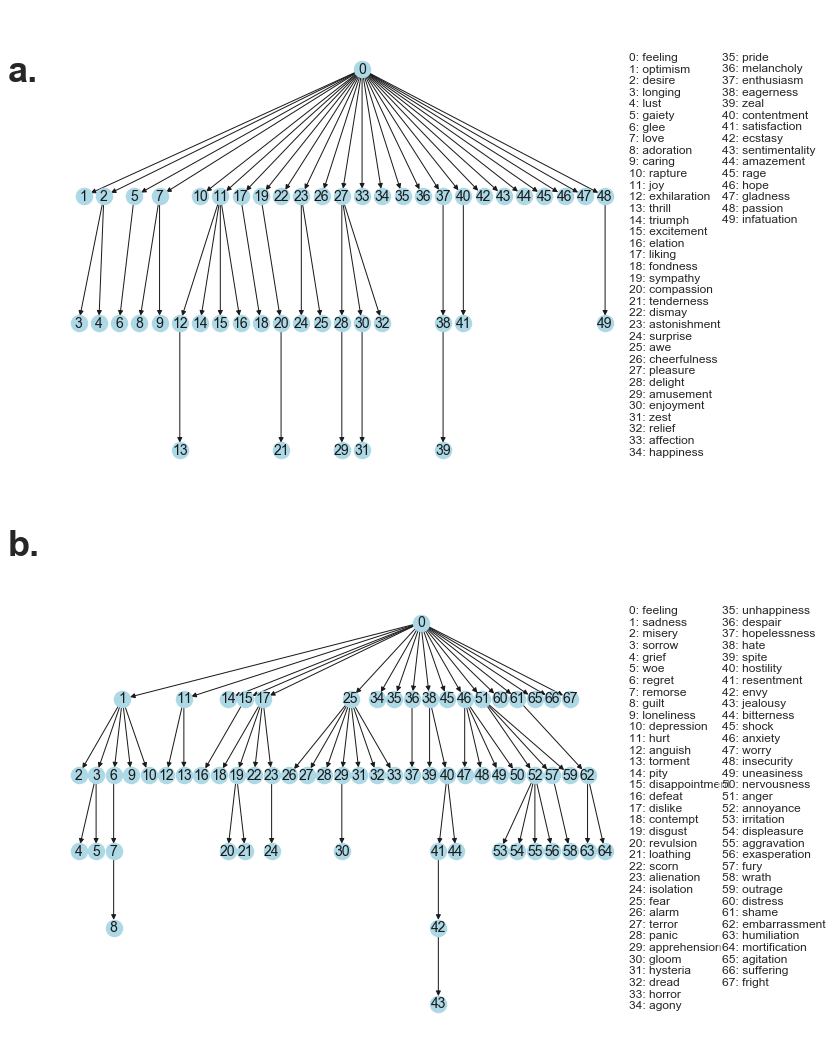

In [4]:
import networkx as nx
import pydot
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

ROOT = 'ROOT'

def make_graph(words, target_s, target_w, lang):
    words = set(words) | {target_w}
    
    # assign each emotion word its most frequent emotion sense
    w2s = dict()
    s2w = dict()
    paths = dict()
    for w in words:
        for s in wn.synsets(w, lang=lang):
            path = s._shortest_hypernym_paths(target_s)
            if not wn.synset(target_s) in path:
                continue
            w2s[w] = s
            s2w[s] = w
            paths[w] = path
            break

    # get parents
    all_senses = set(w2s.values()) | {wn.synset(target_s)}
    graph = {target_w: ROOT}
    for w, path in paths.items():
        ancestors = [s for s in path if s in all_senses]
        for s in ancestors:
            if s == w2s[w]:
                continue
            graph[w] = s2w[s]
            break

    return graph

def draw_graph(graph, ax, nodesize=240, fontsize=14):
    word2idx_pos = dict()
    
    g = nx.DiGraph()
    for node, parent in graph.items():
        g.add_node(node)
        if parent != ROOT:
            g.add_edge(parent, node)
    
    sorted_words = list(nx.topological_sort(g))
    word2idx = {w: i for i, w in enumerate(sorted_words)}
    
    g_sorted = nx.DiGraph()
    for i, w in enumerate(sorted_words):
        g_sorted.add_node(i)
        if i == 0:
            continue
        j = word2idx[graph[w]]
        g_sorted.add_edge(j, i)
    nx.draw(g_sorted, ax=ax, pos=graphviz_layout(g_sorted, prog='dot'), with_labels=True, \
            node_color='lightblue', linewidths=2.0, node_size=nodesize, font_size=fontsize)
    
    textstr = ''
    textstr2 = ''
    max_row = 35
    max_len = np.max([len(w) for w in sorted_words])
    for i, w in enumerate(sorted_words[0:max_row]):
        textstr += ("{i}: {w}".format(i=i,w=w) + '\n')
        if i + max_row < len(sorted_words):
            textstr2 += "{i}: {w}".format(i=i+max_row,w=sorted_words[i+max_row])
            textstr2 += '\n'
            
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    ax.text(0.95 + max_len*0.0105, 0.95, textstr2, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    return ax

fig, axes = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(11.69, 16))
valence = read_table2_1987(table2_1987_path)

words_emotion_eng_pos = [w for w in measures_emotion_eng.keys() if valence[w] >= 0]
graph_pos = make_graph(words_emotion_eng_pos, 'feeling.n.01', 'feeling', 'eng')
axes[0] = draw_graph(graph_pos, axes[0])

words_emotion_eng_neg = [w for w in measures_emotion_eng.keys() if valence[w] < 0]
graph_neg = make_graph(words_emotion_eng_neg, 'feeling.n.01', 'feeling', 'eng')
axes[1] = draw_graph(graph_neg, axes[1])

axes[0].annotate('b.',
            xy=(0, 0.48), xytext=(0, 0.48),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            fontsize=36, weight='bold', ha='center', va='center')
axes[0].annotate('a.',
            xy=(0, 0.93), xytext=(0, 0.93),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            fontsize=36, weight='bold', ha='center', va='center')

img_format = 'svg'
plt.tight_layout()
plt.savefig('images/wn.'+img_format, format=img_format, bbox_inches='tight')




                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     56.24
Date:                Fri, 01 Jan 2021   Prob (F-statistic):           9.66e-29
Time:                        17:33:50   Log-Likelihood:                 171.76
No. Observations:                 116   AIC:                            -331.5
Df Residuals:                     110   BIC:                            -315.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7040      0.096      7.364      0.0

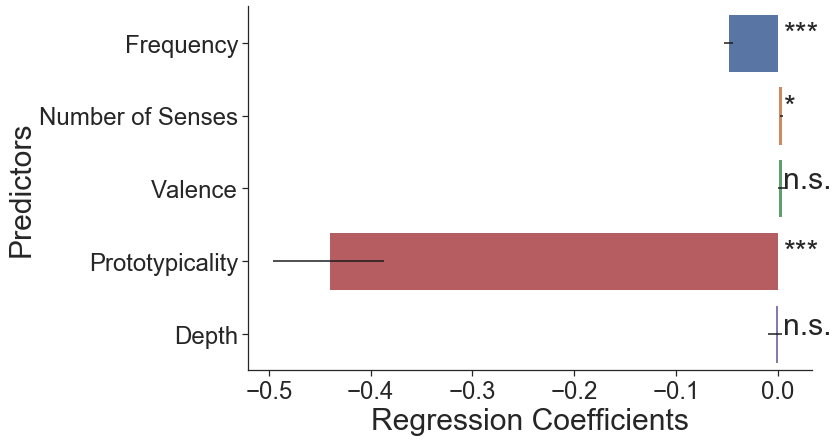

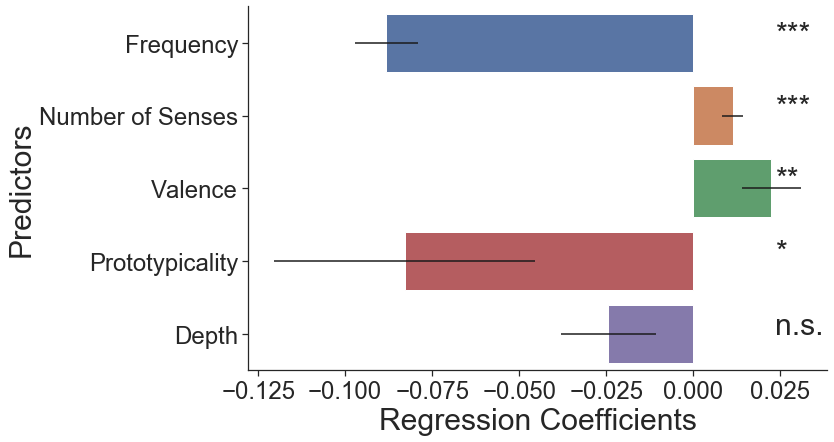

In [6]:
# Other factors in emotion semantic change
from helpers_HTE import get_senses

def get_depth(graph, root):
    depth = dict()
    def depth(node):
        if node == root:
            return 1
        return depth(graph[node]) + 1
    return {node: depth(node) for node in graph}

# similar to main text, SI section 3.1
emotion_root = 'feeling'
t_to_use = 1890

words_emotion_eng = [w for w in measures_emotion_eng.keys()]
graph = make_graph(words_emotion_eng, 'feeling.n.01', emotion_root, 'eng')
depths = get_depth(graph, emotion_root)
words_emotion_eng = [w for w in depths if not w == emotion_root]
freqs = {w: np.log(freqs_all[w][t_to_use]) for w in words_emotion_eng}
senses, _ = get_senses(HTE_senses % ('n', TABLE1_1987), words_emotion_eng, t_to_use)
valence = read_table2_1987(table2_1987_path)

X = {
    'change': [measures_emotion_eng[w] for w in words_emotion_eng], 
    'freqs': [freqs[w] for w in words_emotion_eng], 
    'num_senses': [senses[w] for w in words_emotion_eng],
    'valence': [valence[w] for w in words_emotion_eng],
    'proto': [emotion_emproto_eng[w] for w in words_emotion_eng],
    'proto_emp': [proto[w] for w in words_emotion_eng],
    'depth': [depths[w] for w in words_emotion_eng],
}
formula = 'change ~ ' + ' + '.join(['freqs', 'num_senses', 'valence', 'proto', 'depth',])
model = smf.ols(formula, data=X)
results = model.fit()
print(results.summary())

sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(11.69,6.25))
ax = plot_coefficents(ax, results, ['Frequency', 'Number of Senses', 'Valence', 'Prototypicality', 'Depth',])
sns.despine()
plt.tight_layout()
img_format = 'svg'
plt.savefig('images/other.'+img_format, format=img_format, bbox_inches='tight')

# empirical ratings, SI section 3.3
t_to_use = 1980
freqs2 = {w: np.log(freqs_all[w][t_to_use]) for w in words_emotion_eng}
senses2, _ = get_senses(HTE_senses % ('n', TABLE1_1987), words_emotion_eng, t_to_use)

X['change'] = [measures_emotion_eng_late[w] for w in words_emotion_eng]
X['freqs'] = [freqs2[w] for w in words_emotion_eng]
X['num_senses'] = [senses2[w] for w in words_emotion_eng]

formula = 'change ~ ' + ' + '.join(['freqs', 'num_senses', 'valence', 'proto_emp', 'depth',])
model = smf.ols(formula, data=X)
results = model.fit()
print(results.summary())
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(11.69,6.25))
ax = plot_coefficents(ax, results, ['Frequency', 'Number of Senses', 'Valence', 'Prototypicality', 'Depth',])

sns.despine()
plt.tight_layout()
img_format = 'svg'
plt.savefig('images/empirical.'+img_format, format=img_format, bbox_inches='tight')


